<a href="https://colab.research.google.com/github/sridevibonthu/EVA/blob/master/S9/S9_Assignment_Albumentations_and_Gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# mount the drive where we will save stats and loade our libraries from
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Installation of Latest Albumentations Library

In [2]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-bo3x748z
All libraries are successfully installed!


In [3]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)


[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4')

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
import numpy as np
from eva4datatransforms import AlbumentationTransforms
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=4) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])



# Dataset and Creating Train/Test Split

In [7]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

In [9]:
import numpy as np
dataiter = iter(train_loader)
images, labels = dataiter.next()
i = images[90].numpy()
print(np.max(i), np.min(i))

1.5952917 -1.9257139


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

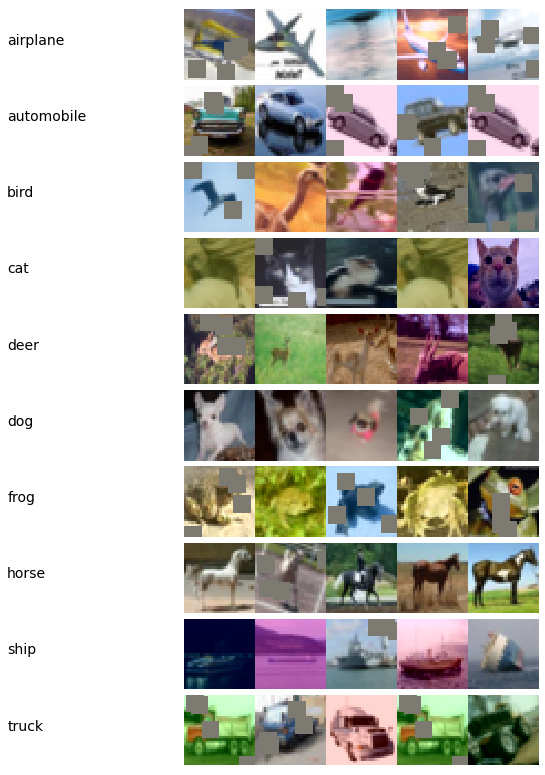

In [10]:
from __future__ import print_function
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Model Creation

We will be calling Resnet18 model here.

We replaced FC with 1x1 as we are not supposed to use FC in this EVA4 librart.

In [12]:
import eva4models 
import torch
model = eva4models.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [13]:
#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 30
L2lambda = 0
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True, L1lambda)

Validation loss decreased (100000.000000 --> 1.240753).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0119, Accuracy: 45.25%; Test set: Average loss: 1.2408, Accuracy: 56.96%
Learning Rate = 0.034482


Validation loss decreased (1.240753 --> 0.904655).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0087, Accuracy: 61.12%; Test set: Average loss: 0.9047, Accuracy: 69.83%
Learning Rate = 0.076180


Validation loss decreased (0.904655 --> 0.836085).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0073, Accuracy: 67.51%; Test set: Average loss: 0.8361, Accuracy: 72.10%
Learning Rate = 0.140062


Validation loss decreased (0.836085 --> 0.820751).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0064, Accuracy: 71.74%; Test set: Average loss: 0.8208, Accuracy: 73.89%
Learning Rate = 0.218418


Validation loss decreased (0.820751 --> 0.599352).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0057, Accuracy: 74.58%; Test set: Average loss: 0.5994, Accuracy: 79.95%
Learning Rate = 0.301793


Validation loss decreased (0.599352 --> 0.535746).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0051, Accuracy: 77.38%; Test set: Average loss: 0.5357, Accuracy: 81.78%
Learning Rate = 0.380124


Validation loss decreased (0.535746 --> 0.490648).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0047, Accuracy: 79.23%; Test set: Average loss: 0.4906, Accuracy: 83.17%
Learning Rate = 0.443958


Epoch: 8, Train set: Average loss: 0.0043, Accuracy: 80.89%; Test set: Average loss: 0.5544, Accuracy: 81.56%
Learning Rate = 0.485591


Validation loss decreased (0.490648 --> 0.471918).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0039, Accuracy: 82.59%; Test set: Average loss: 0.4719, Accuracy: 84.85%
Learning Rate = 0.500000


Validation loss decreased (0.471918 --> 0.445662).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0036, Accuracy: 83.84%; Test set: Average loss: 0.4457, Accuracy: 85.22%
Learning Rate = 0.497193


Epoch: 11, Train set: Average loss: 0.0034, Accuracy: 84.92%; Test set: Average loss: 0.4792, Accuracy: 84.80%
Learning Rate = 0.488865


Validation loss decreased (0.445662 --> 0.445111).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0032, Accuracy: 85.98%; Test set: Average loss: 0.4451, Accuracy: 85.63%
Learning Rate = 0.475201


Validation loss decreased (0.445111 --> 0.382029).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0030, Accuracy: 86.87%; Test set: Average loss: 0.3820, Accuracy: 87.31%
Learning Rate = 0.456506


Validation loss decreased (0.382029 --> 0.350448).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0028, Accuracy: 87.54%; Test set: Average loss: 0.3504, Accuracy: 88.46%
Learning Rate = 0.433198


Epoch: 15, Train set: Average loss: 0.0026, Accuracy: 88.48%; Test set: Average loss: 0.3785, Accuracy: 87.75%
Learning Rate = 0.405798


Epoch: 16, Train set: Average loss: 0.0025, Accuracy: 89.09%; Test set: Average loss: 0.3565, Accuracy: 88.21%
Learning Rate = 0.374918


Epoch: 17, Train set: Average loss: 0.0023, Accuracy: 89.88%; Test set: Average loss: 0.3569, Accuracy: 88.81%
Learning Rate = 0.341247


Validation loss decreased (0.350448 --> 0.315313).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0021, Accuracy: 90.34%; Test set: Average loss: 0.3153, Accuracy: 89.73%
Learning Rate = 0.305538


Validation loss decreased (0.315313 --> 0.296598).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0020, Accuracy: 91.12%; Test set: Average loss: 0.2966, Accuracy: 90.55%
Learning Rate = 0.268588


Epoch: 20, Train set: Average loss: 0.0019, Accuracy: 91.82%; Test set: Average loss: 0.3152, Accuracy: 90.26%
Learning Rate = 0.231223


Epoch: 21, Train set: Average loss: 0.0017, Accuracy: 92.65%; Test set: Average loss: 0.3055, Accuracy: 90.48%
Learning Rate = 0.194278


Validation loss decreased (0.296598 --> 0.295851).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0016, Accuracy: 92.77%; Test set: Average loss: 0.2959, Accuracy: 90.95%
Learning Rate = 0.158577


Validation loss decreased (0.295851 --> 0.288382).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0015, Accuracy: 93.36%; Test set: Average loss: 0.2884, Accuracy: 91.16%
Learning Rate = 0.124919


Validation loss decreased (0.288382 --> 0.286128).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0013, Accuracy: 94.12%; Test set: Average loss: 0.2861, Accuracy: 91.72%
Learning Rate = 0.094054


Validation loss decreased (0.286128 --> 0.281514).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0012, Accuracy: 94.91%; Test set: Average loss: 0.2815, Accuracy: 91.87%
Learning Rate = 0.066674


Validation loss decreased (0.281514 --> 0.281247).  Saving model ...
Epoch: 26, Train set: Average loss: 0.0010, Accuracy: 95.56%; Test set: Average loss: 0.2812, Accuracy: 91.90%
Learning Rate = 0.043388


Validation loss decreased (0.281247 --> 0.271336).  Saving model ...
Epoch: 27, Train set: Average loss: 0.0010, Accuracy: 95.80%; Test set: Average loss: 0.2713, Accuracy: 92.15%
Learning Rate = 0.024718


Validation loss decreased (0.271336 --> 0.269978).  Saving model ...
Epoch: 28, Train set: Average loss: 0.0009, Accuracy: 96.02%; Test set: Average loss: 0.2700, Accuracy: 92.31%
Learning Rate = 0.011081


Validation loss decreased (0.269978 --> 0.266938).  Saving model ...
Epoch: 29, Train set: Average loss: 0.0008, Accuracy: 96.38%; Test set: Average loss: 0.2669, Accuracy: 92.29%
Learning Rate = 0.002780


Validation loss decreased (0.266938 --> 0.264369).  Saving model ...
Epoch: 30, Train set: Average loss: 0.0008, Accuracy: 96.66%; Test set: Average loss: 0.2644, Accuracy: 92.45%
Learning Rate = 0.000002



# GRAD CAM

In [0]:
import cv2
import urllib
import numpy as np
from google.colab.patches import cv2_imshow

def getimage(img, transform, input_size=(32,32)):
  if img.startswith("http"):
      req = urllib.request.urlopen(img)
      arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
      img = cv2.imdecode(arr, -1) # 'Load it as it is'
  else:
    img = cv2.imread(img, 1)
  
  img = img[:,:, -1::-1]
  
  img = np.uint8(cv2.resize(img, input_size))

  return transform(img)


In [0]:
in_images = [
          (0, 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Egyptair.a330-200.su-gce.arp.jpg/1200px-Egyptair.a330-200.su-gce.arp.jpg'),
          (1, 'https://upload.wikimedia.org/wikipedia/commons/5/5b/Riley_4-68_Riviera_1961.jpg'),
          (2, 'https://upload.wikimedia.org/wikipedia/commons/4/45/Eopsaltria_australis_-_Mogo_Campground.jpg'),
          (3, 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/800px-Cat_November_2010-1a.jpg'),
          (4, 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Spotted_deer_in_S.V._zoo%2C_Tirupathi_%28May_2019%29.jpg/1920px-Spotted_deer_in_S.V._zoo%2C_Tirupathi_%28May_2019%29.jpg'),
          (5, 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/75/%22Boxer_dog%22_stand.jpg/1280px-%22Boxer_dog%22_stand.jpg'),
          (6, 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Variegated_golden_frog_%28Mantella_baroni%29_Ranomafana.jpg/800px-Variegated_golden_frog_%28Mantella_baroni%29_Ranomafana.jpg'),
          (7, 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Horseracing_Churchill_Downs.jpg/1920px-Horseracing_Churchill_Downs.jpg'),
          (8, 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Marina_%28ship%2C_2011%29%2C_S%C3%A8te_01.jpg/1920px-Marina_%28ship%2C_2011%29%2C_S%C3%A8te_01.jpg'),
          (9, 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Bergingstruck_%28tow_truck%29.jpg/1280px-Bergingstruck_%28tow_truck%29.jpg')
]
#
images = []
target_classes = []

for i in in_images:
  images.append(getimage(i[1], test_transforms))
  target_classes.append(i[0])
#class_names = ['airplane','automobile','bird','cat','deer',
#               'dog','frog','horse','ship','truck']

In [16]:
model.load_state_dict(torch.load(f"/content/drive/My Drive/{model.name}.pt"))

<All keys matched successfully>

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


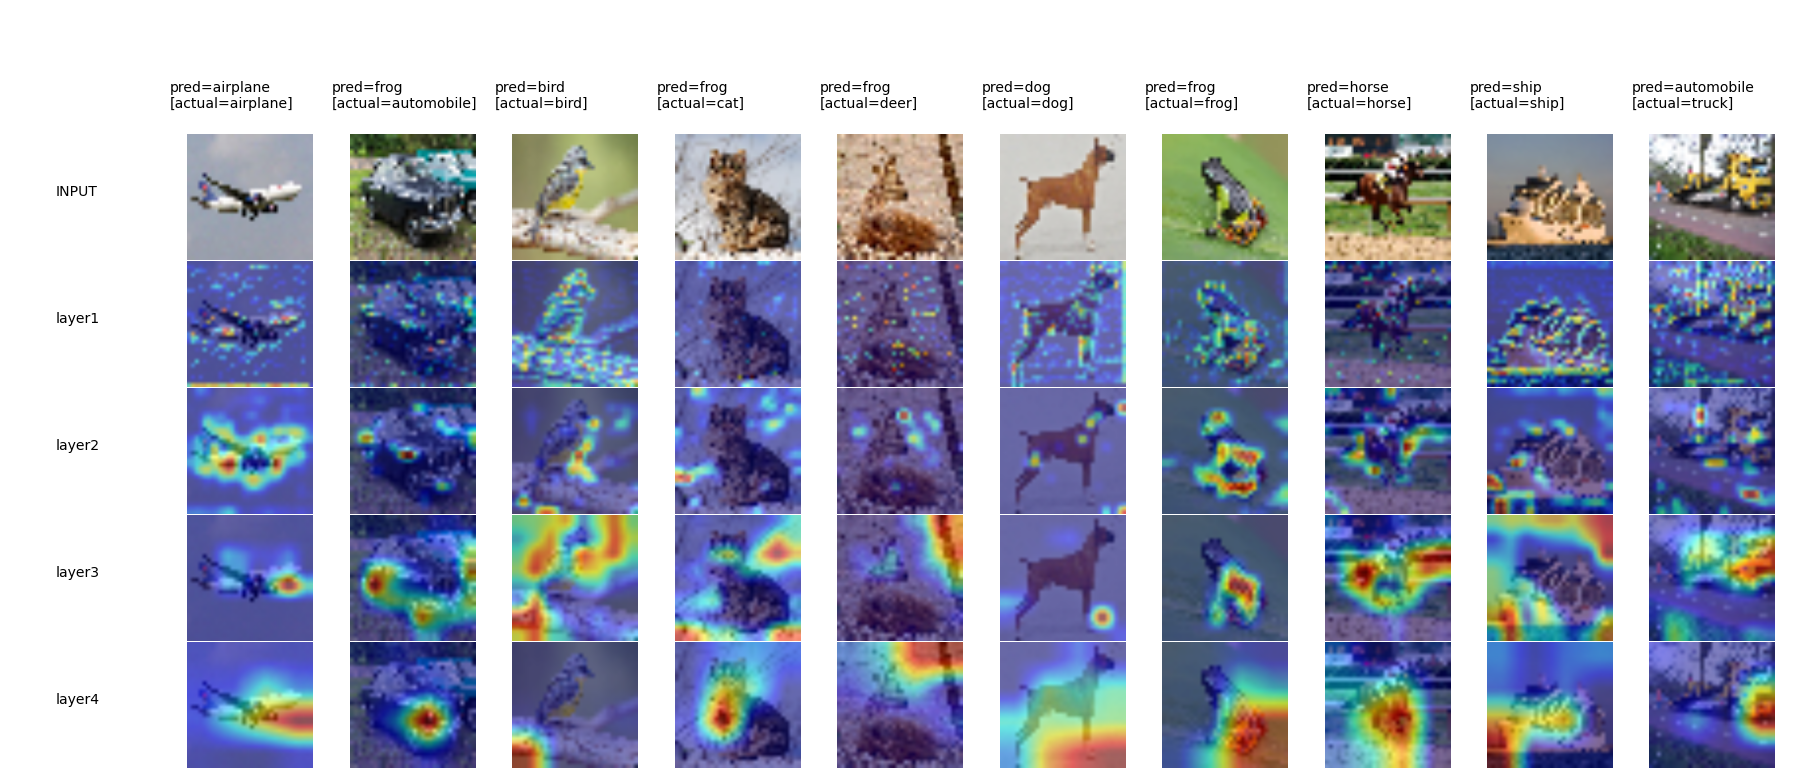

In [17]:
from eva4gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = GRADCAM(images, target_classes, model, target_layers)
PLOT(gradcam_output, images, target_classes, target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)

## Grad Cam using train transformations on test images
* It is predicting based on other features that are not cut out. For example on Dog and Ship

In [0]:
images = []
target_classes = []

for i in in_images:
  images.append(getimage(i[1], train_transforms))
  target_classes.append(i[0])

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


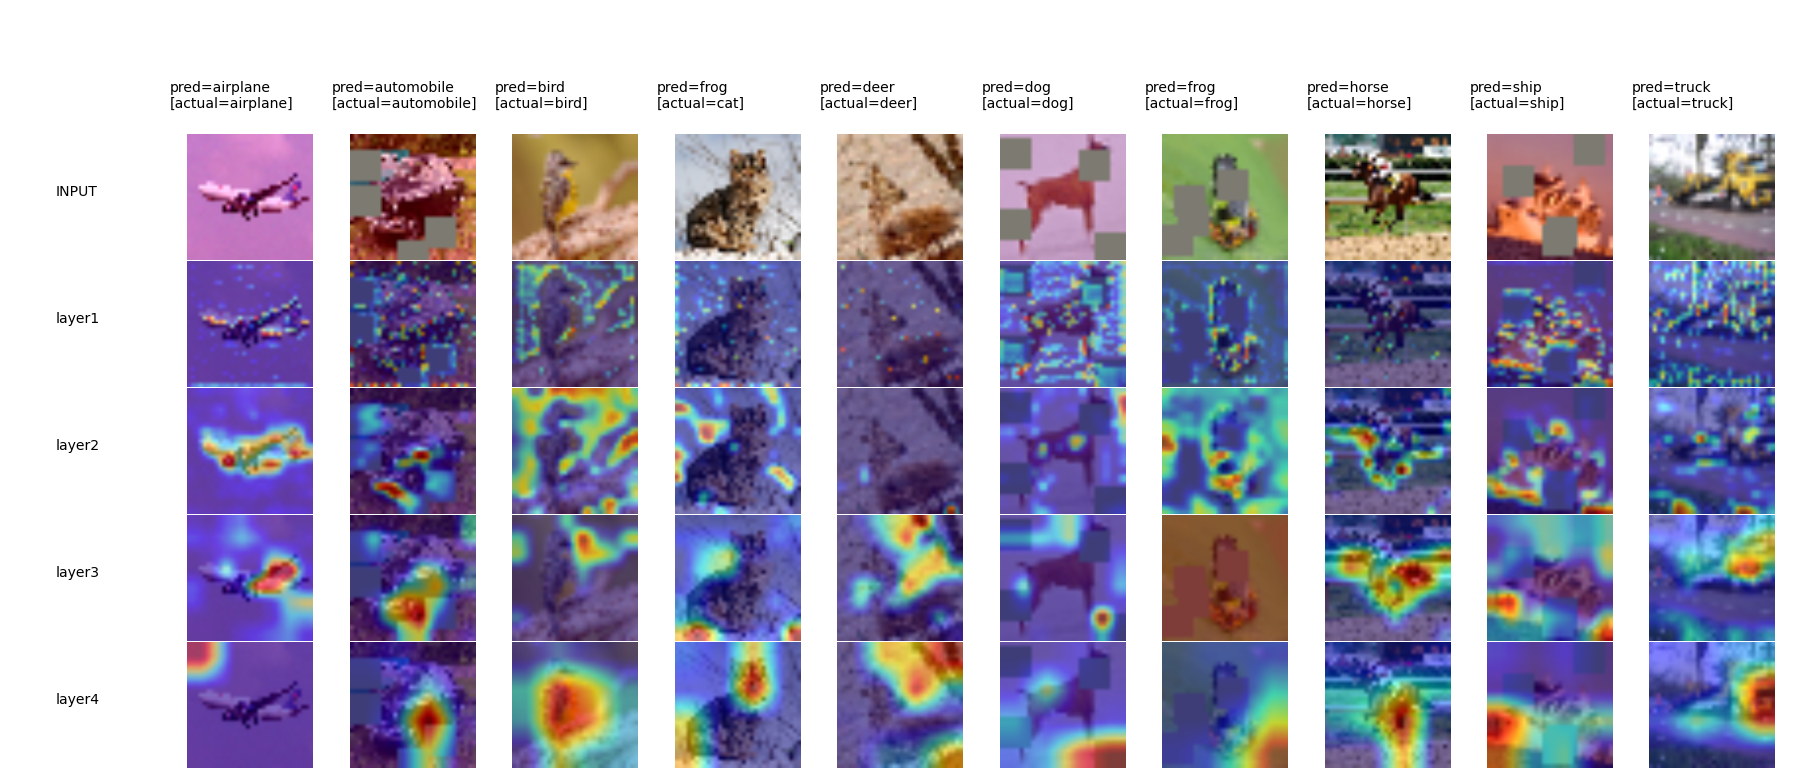

In [19]:
gradcam_output, probs, predicted_classes = GRADCAM(images, target_classes, model, target_layers)
PLOT(gradcam_output, images, target_classes, target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)